In [1]:
%pip install -qU pandas langchain langchain_core langchain-openai matplotlib scikit-learn


Note: you may need to restart the kernel to use updated packages.


In [2]:
# read data in stack-overflow-data.csv

import pandas as pd

df = pd.read_csv('stack-overflow-data.csv')

df.head(10)


,post,tags
0,what is causing this behavior in our c# datet...,c#
1,have dynamic html load as if it was in an ifra...,asp.net
2,how to convert a float value in to min:sec i ...,objective-c
3,.net framework 4 redistributable just wonderi...,.net
4,trying to calculate and print the mean and its...,python
5,how to give alias name for my website i have ...,asp.net
6,window.open() returns null in angularjs it wo...,angularjs
7,identifying server timeout quickly in iphone ...,iphone
8,unknown method key error in rails 2.3.8 unit ...,ruby-on-rails
9,from the include how to show and hide the con...,angularjs


In [3]:
# Truncate the posts to 5000 characters

LENGTH_LIMIT = 5000

df["post"] = df["post"].str[:LENGTH_LIMIT]


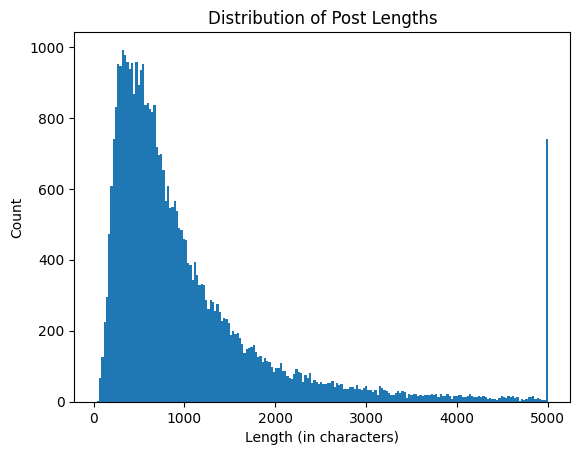

In [4]:
import matplotlib.pyplot as plt

post_lengths = [len(post) for post in df["post"].tolist()]

plt.hist(post_lengths, bins=200)
plt.title('Distribution of Post Lengths')
plt.xlabel('Length (in characters)')
plt.ylabel('Count')
plt.show()


There are 20 unique tags in the dataset.
['c#', 'asp.net', 'objective-c', '.net', 'python', 'angularjs', 'iphone', 'ruby-on-rails', 'ios', 'c', 'sql', 'java', 'jquery', 'css', 'c++', 'php', 'android', 'mysql', 'javascript', 'html']


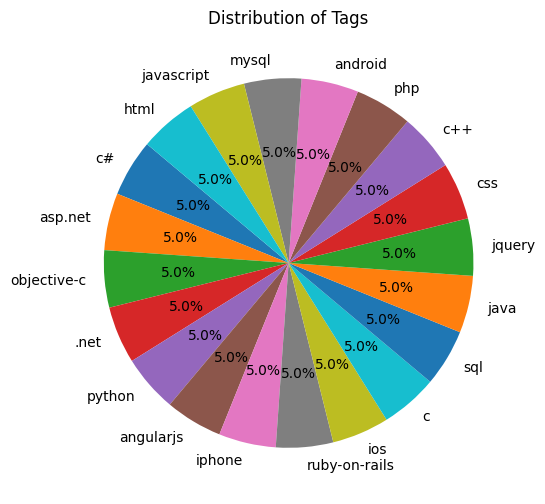

In [5]:
TAGS = list(df['tags'].unique())

print(f"There are {len(TAGS)} unique tags in the dataset.")
# show them
print(TAGS)

plt.figure(figsize=(10, 6))
plt.pie(df['tags'].value_counts(), labels=df['tags'].unique(), autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Tags')
plt.show()


# LLM for prediction

In this section, I want to use an LLM to predict the tag of a post, by first showing it many examples with the correct tag.

In [6]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.25

df_train, df_test = train_test_split(df, test_size=TEST_SIZE, random_state=42)

print(f"There are {len(df_train)} training examples and {len(df_test)} testing examples.")


There are 30000 training examples and 10000 testing examples.


## Simple LLM prediction


In [7]:
from langchain_openai import ChatOpenAI

gpt4o_mini = ChatOpenAI(model="gpt-4o-mini", temperature=0).with_retry(
    wait_exponential_jitter=True, # Add jitter to the exponential backoff
    stop_after_attempt=10,
)


### Read the examples from the file

In [22]:
import json

def read_examples(file_path: str) -> list[tuple[str, str]]:
    examples = []
    with open(file_path, "r") as f:
        for line in f:
            data = json.loads(line)
            post = data["post"][:5000]
            tag = data["tag"]
            examples.append((post, tag))

    assert len(set(post for post, _ in examples)) == len(examples)

    return examples

training_examples = read_examples("training_examples.jsonl")

training_examples[:3]


[('how to maintain the width of drop down list   i have used two drop down lists.    <ol> <li>the 1st drop down list contains 2 values </li> <li>the 2nd drop down list contains 3 values.</li> </ol>   when i select the <code>1st value</code> of the 1st <code>dropdownlist</code> the 2nd <code>dropdownlist</code> gets <code>disabled</code>.    but the problem is  at the time of getting disabled the width of the disabled <code>dropdownlost</code> increases and i do not want that.    can any one please help me out',
  'asp.net'),
 ('removing the status bar in my app  i m making an small game for iphone in opengl.    first i removed the  status bar  by writting    <pre><code>[[uiapplication sharedapplication] setstatusbarhidden:yes]; </code></pre>   which worked  but only removed the status bar when my app began to run. then i modified my project.plist   <pre><code>&lt;key&gt;uistatusbarhidden&lt;/key&gt; &lt;true/&gt; </code></pre>   and now the status bar is never show  just how i wanted. 

In [23]:
def format_examples(posts : list[str], tags : list[str]) -> str:
    assert len(posts) == len(tags)
    examples = ""
    for post, tag in zip(posts, tags):
        examples += f"<post>{post}</post>\n<tag>{tag}</tag>\n\n"
    return examples

# show example with 3 posts

print(format_examples(*zip(*training_examples[:3])))


<post>how to maintain the width of drop down list   i have used two drop down lists.    <ol> <li>the 1st drop down list contains 2 values </li> <li>the 2nd drop down list contains 3 values.</li> </ol>   when i select the <code>1st value</code> of the 1st <code>dropdownlist</code> the 2nd <code>dropdownlist</code> gets <code>disabled</code>.    but the problem is  at the time of getting disabled the width of the disabled <code>dropdownlost</code> increases and i do not want that.    can any one please help me out</post>
<tag>asp.net</tag>

<post>removing the status bar in my app  i m making an small game for iphone in opengl.    first i removed the  status bar  by writting    <pre><code>[[uiapplication sharedapplication] setstatusbarhidden:yes]; </code></pre>   which worked  but only removed the status bar when my app began to run. then i modified my project.plist   <pre><code>&lt;key&gt;uistatusbarhidden&lt;/key&gt; &lt;true/&gt; </code></pre>   and now the status bar is never show  ju

In [24]:
from langchain_core.runnables import Runnable, RunnablePassthrough
from difflib import SequenceMatcher
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableLambda, RunnableParallel

template = """Here are stack overflow posts and their tags.

{examples}

Given a new post, determine which tag best describes it.

Available tags: {tags}

Post: 

<post>
{post}
</post>

Answer with the tag only, no explanation.

Tag:
"""

PROMPT = ChatPromptTemplate.from_template(template)


def create_prompt_chain(examples: list[tuple[str, str]]):
    return RunnableParallel(
        post=RunnablePassthrough(),
        examples=RunnableLambda(
            lambda _: format_examples(*zip(*examples))
        ),
        tags=RunnableLambda(lambda _: TAGS),
    )

def fuzzy_output_parser(output: str) -> str:
    if output.lower() in [tag.lower() for tag in TAGS]:
        return output

    # return the closest tag using a package for similarity
    return max(TAGS, key=lambda x: SequenceMatcher(None, x, output).ratio())

chain = create_prompt_chain(training_examples) | PROMPT | gpt4o_mini | StrOutputParser() | RunnableLambda(fuzzy_output_parser)

chain.invoke("How do I install a package in python?")


'python'

In [25]:
%pip install -qU langchain-community
from langchain_community.callbacks import get_openai_callback


Note: you may need to restart the kernel to use updated packages.


In [26]:
import random

N_PREDICTIONS = 5
SEED = 42

# take at random instead
random_indices = random.Random(SEED).sample(range(len(df_test)), N_PREDICTIONS)
posts_to_predict = df_test["post"].iloc[random_indices].tolist()
tags_to_predict = df_test["tags"].iloc[random_indices].tolist()

with get_openai_callback() as cb:
    predictions = chain.batch(posts_to_predict)

    print(f"Total Tokens: {cb.total_tokens}")
    print(f"Prompt Tokens: {cb.prompt_tokens}")
    print(f"Completion Tokens: {cb.completion_tokens}")
    print(f"Total Cost (USD): ${cb.total_cost}")


print(predictions)


Total Tokens: 55492
Prompt Tokens: 55484
Completion Tokens: 8
Total Cost (USD): $0.008327399999999999
['angularjs', 'sql', 'python', 'c++', 'angularjs']


In [27]:
# test with a single example
# 250 calls = $0.02
# for 10 000 calls =  $0.8

# test with 45 examples : $0.008327399
# for 10 000 calls = $1.85

### Compute the accuracy

In [21]:
correct = sum(1 for prediction, tag in zip(predictions, tags_to_predict) if prediction == tag)

print(f"{correct}/{N_PREDICTIONS} = {correct / N_PREDICTIONS}")

226/250 = 0.904



### See the mistakes

In [13]:
for post, prediction, tag in zip(posts_to_predict, predictions, tags_to_predict):
    if prediction != tag:
        print(f"Post: {post}\n\nPrediction: '{prediction}'\nTag:        '{tag}'\n")
        print("-"*50)
        print("\n")


Post: how to reduce the space between two words. my jsp looks like this sortby: date.i want to reduce the space between sortby: date  how can we reduce the space between the word in ui page.    i have multiple words and all are in the random location.i want to place those words properly

Prediction: 'html'
Tag:        'css'

--------------------------------------------------


Post: auto increment the alphanumeric characters id  i want to auto increment the alphanumeric character s id and i want to savi it in to my database.    for example:   <pre><code>example-001 example-002 example-003 example-004 example-005 </code></pre>

Prediction: 'sql'
Tag:        'php'

--------------------------------------------------


Post: update server database from localhost  i am using codeigniter  php and mysql  for project management we use svn  from which we can update and commit project  and it reflects on the server automatically  but if i made any change in localhost database  i have to update i

# Find errors in training data

In this section, I want to find the posts in the training data that are most often misclassified. Then, I can provide the LLM with more examples to improve its accuracy.


In [185]:
import random

N_PREDICTIONS = min(100, len(df_train))

# i want to find N_PREDICTIONS random posts in the training data, that are not in the training examples

# Get the posts from the training examples
training_example_posts = [example[0] for example in training_examples]

# Find posts in df_train that are not in training examples
new_posts = [post for post in df_train["post"].tolist() if post not in training_example_posts]

# Randomly select N_PREDICTIONS posts from new_posts
selected_posts = random.sample(new_posts, N_PREDICTIONS)

# Get the corresponding tags for the selected posts
selected_tags = [df_train[df_train["post"] == post]["tags"].iloc[0] for post in selected_posts]


assert not any(post in training_example_posts for post in selected_posts)

In [187]:
predictions = chain.batch(selected_posts)

print(predictions)

['sql', 'ios', '.net', 'objective-c', 'javascript', 'c++', '.net', 'ios', 'html', 'java', 'iphone', 'c++', 'javascript', 'php', 'sql', 'iphone', 'mysql', 'mysql', 'html', 'sql', 'jquery', 'android', 'angularjs', 'c#', 'c++', 'android', 'c++', 'c++', 'mysql', 'ios', 'ios', 'iphone', 'mysql', 'html', 'sql', 'python', 'php', 'sql', 'javascript', 'ios', 'python', 'objective-c', 'iphone', 'sql', '.net', 'css', 'android', 'java', 'ios', 'ios', 'android', 'ios', 'css', 'objective-c', 'mysql', 'mysql', 'html', 'ruby-on-rails', 'c++', 'javascript', 'iphone', 'jquery', 'php', 'css', '.net', 'ios', 'angularjs', 'angularjs', 'html', 'objective-c', 'objective-c', 'jquery', 'c++', 'android', 'jquery', 'c#', 'android', 'android', 'c++', 'sql', 'ruby-on-rails', 'c++', 'mysql', 'c', 'ios', '.net', 'ruby-on-rails', 'c', 'php', 'android', '.net', 'mysql', '.net', 'javascript', 'php', 'objective-c', 'ios', 'html', 'c++', 'angularjs']


In [188]:
### Find errors
errors = [
    (post, prediction, tag)
    for post, prediction, tag in zip(selected_posts, predictions, selected_tags)
    if prediction != tag
]

print(f"There are {len(errors)} errors in the training data.")

# show the errors
for post, prediction, tag in errors:
    print(f"Post: {post}\n\nPrediction: '{prediction}'\nTag:        '{tag}'\n")
    print("-"*50)
    print("\n")


There are 17 errors in the training data.
Post: how to display annotation view without clicking on pin in mapview   i have implemented one map application in which i have display pin animation for current location.when i click on the pin at that time annotation view will open. but i want to display annotation view without clicking on pin.is it possible if possible then please give me idea about that.    thanks in advance.

Prediction: 'ios'
Tag:        'iphone'

--------------------------------------------------


Post: cannot connect to honeywell sl22 captuvo hardware  i m just getting started with honeywell captuvo sl22 and ipod touch. i have successfully built and deployed the two included sample sdk apps (sdktestsample and mpos) on the device and they both work flawlessly. i am now trying to create my first simple test of the device but i am getting stuck trying to make the initial connection to the scanner hardware. i am using :    xcode 6.1 sdk 2.19.742.xxxxx firmware rev 45.12  

In [191]:
# For each tag, get the prediction error

for tag_ in TAGS:
    errors_for_tag = [
        (post, prediction, tag)
        for post, prediction, tag in errors
        if tag == tag_
    ]
    print(f"Tag: {tag_}")
    print(f"There are {len(errors_for_tag)} errors for this tag.")
    print("Most often predicted tags:")
    print(pd.Series([prediction for _, prediction, _ in errors_for_tag]).value_counts().head(5))
    print("-"*50)
    print("\n")


Tag: c#
There are 1 errors for this tag.
Most often predicted tags:
.net    1
Name: count, dtype: int64
--------------------------------------------------


Tag: asp.net
There are 0 errors for this tag.
Most often predicted tags:
Series([], Name: count, dtype: int64)
--------------------------------------------------


Tag: objective-c
There are 2 errors for this tag.
Most often predicted tags:
iphone    1
ios       1
Name: count, dtype: int64
--------------------------------------------------


Tag: .net
There are 0 errors for this tag.
Most often predicted tags:
Series([], Name: count, dtype: int64)
--------------------------------------------------


Tag: python
There are 0 errors for this tag.
Most often predicted tags:
Series([], Name: count, dtype: int64)
--------------------------------------------------


Tag: angularjs
There are 0 errors for this tag.
Most often predicted tags:
Series([], Name: count, dtype: int64)
--------------------------------------------------


Tag: ipho

In [192]:
# Now we want to store these posts in a file, one per line, so we can use them as examples for the LLM

import json

posts_and_tags = [(post, tag) for post, _, tag in errors]



# Append the posts and tags to the file
with open("training_examples.jsonl", "a") as f:
    for post, tag in posts_and_tags:
        f.write(json.dumps({"post": post, "tag": tag}) + "\n")



### With tool use (not useful)

In this section, I force the LLM to output a valid tag using a tool call. 

But in the end, it's not very useful and in the end I use a fuzzy match to correct some rare mistakes (see `fuzzy_output_parser`)

In [47]:
%pip install -qU pydantic

Note: you may need to restart the kernel to use updated packages.


In [87]:
from pydantic import BaseModel
from typing import Literal

# an enum of the tags
type Tag = Literal['c#', 'asp.net', 'objective-c', '.net', 'python', 'angularjs', 'iphone', 'ruby-on-rails', 'ios', 'c', 'sql', 'java', 'jquery', 'css', 'c++', 'php', 'android', 'mysql', 'javascript', 'html']


class Prediction(BaseModel):
    tag: Tag

chain_with_tool = create_prompt_chain(training_examples[:3]) | PROMPT | gpt4o_mini.with_structured_output(Prediction)

chain_with_tool.invoke("How do I install a package in python?")


Prediction(tag='python')

In [88]:
# batch 100 predictions

# predictions_with_tool = chain_with_tool.batch(posts_to_predict)

print(predictions_with_tool)

[Prediction(tag='c++'), Prediction(tag='php'), Prediction(tag='angularjs'), Prediction(tag='c++'), Prediction(tag='asp.net'), Prediction(tag='sql'), Prediction(tag='c++'), Prediction(tag='sql'), Prediction(tag='iphone'), Prediction(tag='php'), Prediction(tag='css'), Prediction(tag='angularjs'), Prediction(tag='java'), Prediction(tag='java'), Prediction(tag='jquery'), Prediction(tag='angularjs'), Prediction(tag='sql'), Prediction(tag='c#'), Prediction(tag='c#'), Prediction(tag='ios'), Prediction(tag='c'), Prediction(tag='c#'), Prediction(tag='mysql'), Prediction(tag='php'), Prediction(tag='sql'), Prediction(tag='iphone'), Prediction(tag='sql'), Prediction(tag='ios'), Prediction(tag='asp.net'), Prediction(tag='c#'), Prediction(tag='ruby-on-rails'), Prediction(tag='java'), Prediction(tag='jquery'), Prediction(tag='.net'), Prediction(tag='java'), Prediction(tag='python'), Prediction(tag='asp.net'), Prediction(tag='c++'), Prediction(tag='.net'), Prediction(tag='python'), Prediction(tag='htm

### Compute the accuracy

In [92]:
correct = sum(1 for prediction, tag in zip(predictions_with_tool, tags_to_predict) if prediction.tag == tag)

print(f"{correct}/{N_PREDICTIONS} = {correct / N_PREDICTIONS}")

88/100 = 0.88
